In [2]:
import pyro 
import torch 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
import pyro.distributions as dist
from torch.nn import Embedding
from torch.autograd import Variable
import ast
from collections import Counter 
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TracePredictive, EmpiricalMarginal

In [4]:
dat = pd.read_csv('./data/cleaned_documents.csv')

In [5]:
E = 10 # size of embedding
sent = []
for each in dat.text:
    sent = sent + ast.literal_eval(each)
W = len(np.unique(sent))

In [6]:
print(W)

15673


In [7]:
words= np.unique(sent)
word2idx = {word:idx for idx, word in enumerate(words)}
idx2word = {idx:word for idx, word in enumerate(words)}

In [8]:
uni_freq = Counter(words)

In [9]:
for each in uni_freq:
    uni_freq[each] = uni_freq[each]**0.75
deno = sum(uni_freq.values())
for each in uni_freq:
    uni_freq[each] = uni_freq[each]/deno


### For each document in the corpus, we get x_n^+ and x_n^- by looking at context window and negative sampling. 
Ref : https://arxiv.org/pdf/1711.03946.pdf

In [10]:
# Hard coding context window size to 3.
c = 2
neg_samples = 2*c
def get_pos_neg_sample(dat):
    x_plus = []
    x_neg = []
    uni_keys = list(uni_freq.keys())
    uni_values = list(uni_freq.values())
    for each in dat.text:
        x_plus_n = []
        x_neg_n = []
        sentence = ast.literal_eval(each)
        random_sample = np.random.choice(uni_keys, len(sentence)*neg_samples, p = uni_values)
        r_i = 0
        for idx, token in enumerate(sentence):
            context = sentence[max(idx-c,0):min(idx+c+1, len(sentence))]
            context.remove(token)
            for every in context:
                x_plus_n.append((word2idx[token], word2idx[every]))
                
            for sample in random_sample[r_i:r_i+len(context)]:
                x_neg_n.append((word2idx[token], word2idx[sample]))
            r_i+=len(context)
            
        x_plus.append(x_plus_n)
        x_neg.append(x_neg_n)
    return x_plus, x_neg

In [11]:
x_plus, x_neg = get_pos_neg_sample(dat)

# Stage 1 : Update U,V using sgd


In [12]:
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        value = marginal[:,i]
        site_stats[site_name] = np.mean(value,axis=0)
    return site_stats

def wrapped_model(X_plus, X_neg,d_i):
    pyro.sample("prediction", dist.Delta(model(X_plus, X_neg,d_i)))



In [13]:
def model(X_plus,X_neg, d_i):
    lamb = 0.01
    phi = 0.01
    annealed_rate = 0.001
    alpha = 0.999
    n_iter = 100
    U = pyro.sample("U",dist.MultivariateNormal(torch.zeros(W,E), lamb**2 *torch.eye(E)))
    V = pyro.sample("V",dist.MultivariateNormal(torch.zeros(W,E), lamb**2 *torch.eye(E)))
    X = torch.cat((X_plus,X_neg))
    Y = torch.tensor([float(1) for each in range(len(X_plus))] + [float(0) for each in range(len(X_neg))])
    with pyro.plate('observations'):
        logit = torch.bmm(U[X[:,0]].view(U[X[:,0]].shape[0], 1, E) ,(V[X[:,1]]+d_i).view((V[X[:,1]]+d_i).shape[0],E,1))
        target = pyro.sample('obs', dist.Bernoulli(logits=logit), obs=Y)
    return U

In [14]:
guide = AutoDiagonalNormal(model)
optim = Adam({"lr":0.01})
svi = SVI(model,guide,optim,loss=Trace_ELBO())

In [17]:
def train(x_plus,x_neg):
    lamb = 0.01
    phi = 0.01
    annealed_rate = 0.001
    alpha = 0.999
    n_iter = 100
    losses = []
    logProbList = []
    pyro.clear_param_store()
    for i in range(len(x_plus)):
        X_plus = torch.tensor(x_plus[0])
        X_neg = torch.tensor(x_neg[0])
        d_i = Variable(torch.distributions.MultivariateNormal( torch.zeros(E), phi*torch.eye(E)).rsample(), requires_grad=True)
        posterior = svi.run(X_plus,X_neg, d_i)
        trace_pred = TracePredictive(wrapped_model, posterior, num_samples=1000)
        post_pred = trace_pred.run(X_plus, X_neg, d_i)
        post_summary = summary(post_pred, sites= ['U', 'V'])
        U = torch.tensor(post_summary["U"])
        V = torch.tensor(post_summary["V"])
        logProb = torch.sum(-torch.log(1+torch.exp(-torch.bmm(U[X_plus[:,0]].view(U[X_plus[:,0]].shape[0], 1, E) ,(V[X_plus[:,1]]+d_i).view((V[X_plus[:,1]]+d_i).shape[0],E,1)))))
        logProb += torch.sum(-torch.log(1+torch.exp(-torch.bmm(-U[X_neg[:,0]].view(U[X_neg[:,0]].shape[0], 1, E) ,(V[X_neg[:,1]]+d_i).view((V[X_neg[:,1]]+d_i).shape[0], E, 1)))))
        for j in range(n_iter):
            logProb = torch.sum(-torch.log(1+torch.exp(-torch.bmm(U[X_plus[:,0]].view(U[X_plus[:,0]].shape[0], 1, E) ,(V[X_plus[:,1]]+d_i).view((V[X_plus[:,1]]+d_i).shape[0],E,1)))))
            logProb += torch.sum(-torch.log(1+torch.exp(-torch.bmm(-U[X_neg[:,0]].view(U[X_neg[:,0]].shape[0], 1, E) ,(V[X_neg[:,1]]+d_i).view((V[X_neg[:,1]]+d_i).shape[0], E, 1)))))
            d_i.retain_grad()
            logProb.backward(retain_graph=True)
            tmp=d_i.grad
            d_i = d_i+0.001*tmp
        print(logProb)
        logProbList.append(logProb)
        loss = svi.step(X_plus,X_neg, d_i) 
        losses.append(loss)
    return losses
losses = train(x_plus,x_neg)

tensor(-1129.0361, grad_fn=<AddBackward0>)
tensor(-1126.6790, grad_fn=<AddBackward0>)
tensor(-1125.4946, grad_fn=<AddBackward0>)
tensor(-1132.4634, grad_fn=<AddBackward0>)
tensor(-1130.6384, grad_fn=<AddBackward0>)
tensor(-1128.2261, grad_fn=<AddBackward0>)
tensor(-1131.5200, grad_fn=<AddBackward0>)
tensor(-1129.9095, grad_fn=<AddBackward0>)
tensor(-1128.6025, grad_fn=<AddBackward0>)
tensor(-1145.6838, grad_fn=<AddBackward0>)
tensor(-1126.7788, grad_fn=<AddBackward0>)
tensor(-1125.9921, grad_fn=<AddBackward0>)
tensor(-1130.7366, grad_fn=<AddBackward0>)
tensor(-1123.2223, grad_fn=<AddBackward0>)
tensor(-1138.2379, grad_fn=<AddBackward0>)
tensor(-1121.7394, grad_fn=<AddBackward0>)
tensor(-1133.7161, grad_fn=<AddBackward0>)
tensor(-1121.1470, grad_fn=<AddBackward0>)
tensor(-1114.3088, grad_fn=<AddBackward0>)
tensor(-1132.1365, grad_fn=<AddBackward0>)
tensor(-1128.6951, grad_fn=<AddBackward0>)
tensor(-1124.7097, grad_fn=<AddBackward0>)
tensor(-1118.8850, grad_fn=<AddBackward0>)
tensor(-112

KeyboardInterrupt: 

In [21]:
lamb = 0.01
phi = 0.01
annealed_rate = 0.001
alpha = 0.999
n_iter = 100
    
d_i = Variable(torch.distributions.MultivariateNormal( torch.zeros(E), phi*torch.eye(E)).rsample(), requires_grad=True)   
posterior = svi.run(torch.tensor(x_plus[0]), torch.tensor(x_neg[0]),d_i)    

In [31]:
U = torch.zeros_like(guide(torch.tensor(x_plus[0]), torch.tensor(x_neg[0]),d_i)["U"])
for i in range(1000):
    U += model(torch.tensor(x_plus[0]), torch.tensor(x_neg[0]),d_i)[0]
print(U/1000)

tensor([[-1.0636e-04, -8.3086e-05,  1.6289e-04,  ..., -4.4320e-05,
          1.8385e-04,  3.1809e-04],
        [-2.7221e-04, -7.1052e-05, -1.0818e-04,  ...,  2.7451e-04,
         -1.9074e-04, -2.3317e-04],
        [-2.6649e-05, -1.8299e-04,  7.2109e-05,  ...,  4.3549e-05,
          4.0414e-04, -7.4491e-05],
        ...,
        [-4.4139e-04,  6.5478e-05,  4.0835e-05,  ..., -2.9574e-04,
          7.7738e-05,  3.0325e-04],
        [-9.2244e-05,  2.0924e-04, -2.2840e-04,  ...,  6.9963e-05,
         -1.1844e-04,  3.4485e-04],
        [-1.5655e-04, -8.6267e-04, -2.5109e-04,  ..., -4.3236e-05,
          3.2367e-04,  5.5715e-04]])


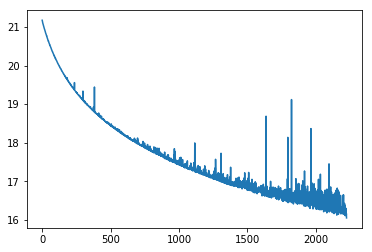

In [75]:
values = loss.split("\n")
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses)),np.log(np.array(losses)))

In [74]:
losses[-1]/(10**7)

0.934443840625

True

In [25]:
[float(i) for i in values if i!=""]

[1561671171.09375,
 1570914633.78125,
 1567316751.75,
 1561656642.3125,
 1559710694.65625,
 1554543836.625,
 1554752426.25,
 1548921725.03125,
 1555127647.9375,
 1554726222.8125,
 1542009863.53125,
 1548791988.5,
 1540243634.6875,
 1539675396.59375,
 1543257644.5,
 1533821593.28125,
 1536872118.84375,
 1530903000.59375,
 1538510529.15625,
 1526119167.53125,
 1534365605.875,
 1527507651.3125,
 1532217694.625,
 1523670672.3125,
 1512294690.3125,
 1513435943.21875,
 1516007653.1875,
 1509955373.59375,
 1514277067.59375,
 1514765097.59375,
 1508084652.25,
 1499524512.96875,
 1495608523.9375,
 1505934219.03125,
 1526150823.3125,
 1500640448.625,
 1493702265.3125,
 1496613612.375,
 1494567860.65625,
 1488709856.59375,
 1491633471.40625,
 1493656356.03125,
 1481707506.1875,
 1477418270.375,
 1483705676.78125,
 1474035208.84375,
 1490414857.34375,
 1473232231.21875,
 1469732912.3125,
 1480626476.8125,
 1474276828.0,
 1469409066.3125,
 1463760162.625,
 1466551103.6875,
 1461347074.875,
 1462224

In [10]:
values

['1561671171.09375',
 '1570914633.78125',
 '1567316751.75',
 '1561656642.3125',
 '1559710694.65625',
 '1554543836.625',
 '1554752426.25',
 '1548921725.03125',
 '1555127647.9375',
 '1554726222.8125',
 '1542009863.53125',
 '1548791988.5',
 '1540243634.6875',
 '1539675396.59375',
 '1543257644.5',
 '1533821593.28125',
 '1536872118.84375',
 '1530903000.59375',
 '1538510529.15625',
 '1526119167.53125',
 '1534365605.875',
 '1527507651.3125',
 '1532217694.625',
 '1523670672.3125',
 '1512294690.3125',
 '1513435943.21875',
 '1516007653.1875',
 '1509955373.59375',
 '1514277067.59375',
 '1514765097.59375',
 '1508084652.25',
 '1499524512.96875',
 '1495608523.9375',
 '1505934219.03125',
 '1526150823.3125',
 '1500640448.625',
 '1493702265.3125',
 '1496613612.375',
 '1494567860.65625',
 '1488709856.59375',
 '1491633471.40625',
 '1493656356.03125',
 '1481707506.1875',
 '1477418270.375',
 '1483705676.78125',
 '1474035208.84375',
 '1490414857.34375',
 '1473232231.21875',
 '1469732912.3125',
 '1480626476.

In [46]:
lamb = 0.01
phi = 0.01
annealed_rate = 0.001
alpha = 0.999
n_iter = 100
loss = []
U = Variable(torch.distributions.MultivariateNormal(torch.zeros(W,E), lamb**2 *torch.eye(E)).rsample(),requires_grad=True)
V = Variable(torch.distributions.MultivariateNormal(torch.zeros(W,E), lamb**2 *torch.eye(E)).rsample(),requires_grad=True)
for _ in range(5):
    for n in range(len(x_plus)):
        annealed_rate = annealed_rate * alpha
        d_i = Variable(torch.distributions.MultivariateNormal( torch.zeros(E), phi*torch.eye(E)).rsample(), requires_grad=True)
        X_plus = torch.tensor(x_plus[n])
        X_neg = torch.tensor(x_neg[n])
        #SGD for d_i
        for iterat in range(n_iter):
            # Loss function
            logProb = torch.sum(-torch.log(1+torch.exp(-torch.bmm(U[X_plus[:,0]].view(U[X_plus[:,0]].shape[0], 
                                                                                      1,
                                                                                      E) ,
                                                                  (V[X_plus[:,1]]+d_i).view((V[X_plus[:,1]]+d_i).shape[0],
                                                                                            E,
                                                                                            1)))))
            logProb += torch.sum(-torch.log(1+torch.exp(-torch.bmm(-U[X_neg[:,0]].view(U[X_neg[:,0]].shape[0], 
                                                                                      1,
                                                                                      E) ,
                                                                  (V[X_neg[:,1]]+d_i).view((V[X_neg[:,1]]+d_i).shape[0],
                                                                                            E,
                                                                                            1)))))
            d_i.retain_grad()
            logProb.backward()
            tmp=d_i.grad
            d_i = d_i+tmp
    #         if iterat ==0 and n%10==0:
    #             print("Inner Iteration 0:", logProb)
    #         if iterat==n_iter-1 and n%10==0:
    #             print("Inner Last Iteration:", logProb)

        # SGD for U_i, V_j
        logProb = torch.sum(-torch.log(1+torch.exp(-torch.bmm(U[X_plus[:,0]].view(U[X_plus[:,0]].shape[0], 
                                                                                  1,
                                                                                  E) ,
                                                              (V[X_plus[:,1]]+d_i).view((V[X_plus[:,1]]+d_i).shape[0],
                                                                                        E,
                                                                                        1)))))
#         logProb += torch.sum(-torch.log(1+torch.exp(-torch.bmm(-U[X_neg[:,0]].view(U[X_neg[:,0]].shape[0], 
#                                                                                   1,
#                                                                                   E) ,
#                                                               (V[X_neg[:,1]]+d_i).view((V[X_neg[:,1]]+d_i).shape[0],
#                                                                                         E,
#                                                                                         1)))))

        loss.append(logProb)
        U.retain_grad()
        V.retain_grad()
        logProb.backward()
        Ugrad = U.grad
        Vgrad = V.grad
        print("Iteration : ", n+1)
        print(logProb)
        U = U + annealed_rate * Ugrad
        V = V + annealed_rate * Vgrad
    

Iteration :  1
tensor(-555.9132, grad_fn=<SumBackward0>)
Iteration :  2
tensor(-1132.6013, grad_fn=<SumBackward0>)
Iteration :  3
tensor(-519.8682, grad_fn=<SumBackward0>)
Iteration :  4
tensor(-295.2700, grad_fn=<SumBackward0>)
Iteration :  5
tensor(-439.4476, grad_fn=<SumBackward0>)
Iteration :  6
tensor(-525.4031, grad_fn=<SumBackward0>)
Iteration :  7
tensor(-400.6442, grad_fn=<SumBackward0>)
Iteration :  8
tensor(-508.7788, grad_fn=<SumBackward0>)
Iteration :  9
tensor(-328.5576, grad_fn=<SumBackward0>)
Iteration :  10
tensor(-822.0672, grad_fn=<SumBackward0>)
Iteration :  11
tensor(-237.0509, grad_fn=<SumBackward0>)
Iteration :  12
tensor(-691.7576, grad_fn=<SumBackward0>)
Iteration :  13
tensor(-256.4661, grad_fn=<SumBackward0>)
Iteration :  14
tensor(-453.3183, grad_fn=<SumBackward0>)
Iteration :  15
tensor(-517.0800, grad_fn=<SumBackward0>)
Iteration :  16
tensor(-403.4257, grad_fn=<SumBackward0>)
Iteration :  17
tensor(-489.3682, grad_fn=<SumBackward0>)
Iteration :  18
tensor

KeyboardInterrupt: 

In [ ]:
def model(X_plus,X_neg):
    with pyro.plate('component', W):
        lamb = 5
        U = pyro.sample('U', dist.MultivariateNormal(loc = torch.zeros(E), scale = lamb*torch.eye(E)), requires_gradient=True)
        V = pyro.sample('V', dist.MultivariateNormal(loc = torch.zeros(E), scale = lamb*torch.eye(E)), requires_gradient=True)
    phi = 10
    d_i = pyro.sample('d_i', dist.MultivariateNormal(loc = torch.zeros(E), scale = phi*torch.eye(E)),requires_gradient=True)
                                          
    dfx, = grad(logProb,d_i,create_graph=True)
    for i in range(100):
        # Loss function
        logProb = torch.log(torch.sigmoid(torch.dot(U[X_plus[0][0]],V[X_plus[0][1]]+d_i))
        for iteration in range(1,len(X_plus)):
            i,j = X_plus[iteration]
            logProb += torch.log(torch.sigmoid(torch.dot(U[i],V[j]+d_i))
        for i,j in X_neg:
  T          logProb += torch.log(torch.sigmoid(torch.dot(-U[i],V[j]+d_i))
        logProb.backward()
        with torch.no_grad():
            d_i = d_i-0.001*d_i.grad 
    pred 
    
    with pyro.plate('data', len(data)):
        pass


In [ ]:
# logProb = torch.Value(0,requires_gradient=True)


# Stage 2 : Fix U,V and update d (doc vector) using SVI 